In [264]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [265]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [266]:
len(dataset)

60000

In [267]:
image, label = dataset[0]
image.permute(1,2,0).shape

torch.Size([28, 28, 1])

image.shape: torch.Size([1, 28, 28])
Label: 5


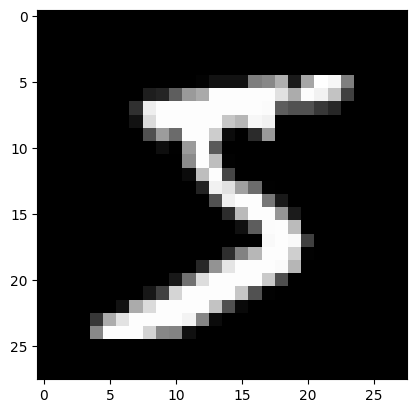

In [268]:
image, label = dataset[0]
print("image.shape:", image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print("Label:", label)

In [269]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [270]:
batch_size = 128

In [271]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


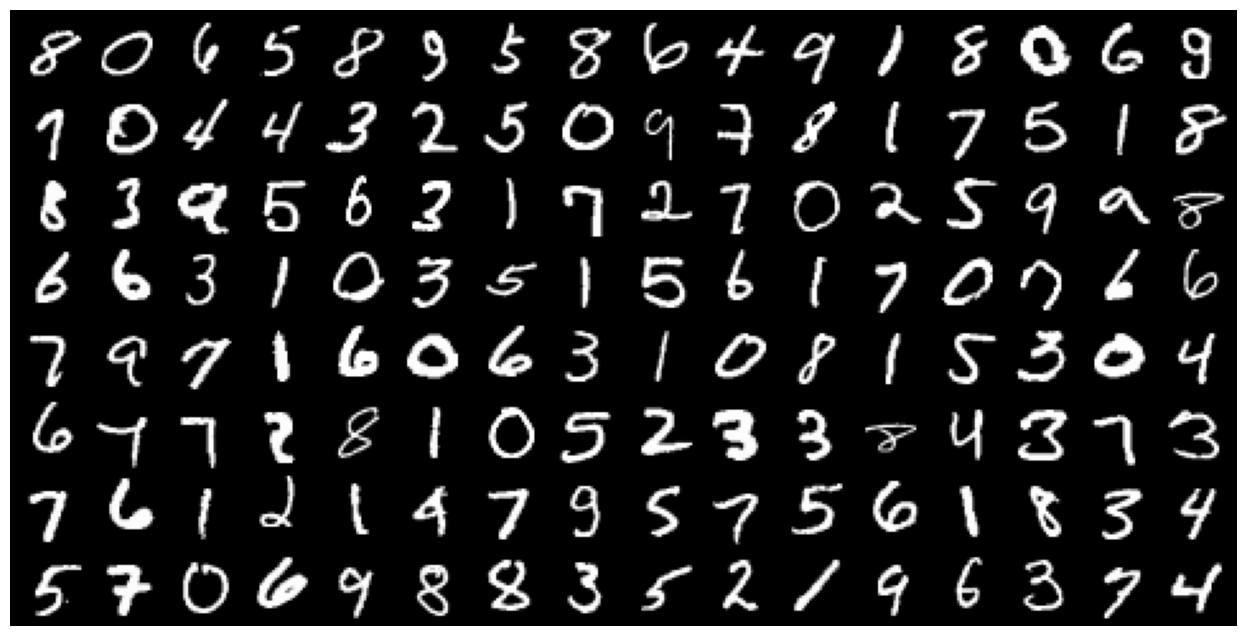

In [272]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [273]:
for images, labels in train_loader:
    print('images.shape:',images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:',inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [274]:
input_size = inputs.shape[-1]
hidden_size = 32

In [275]:
layer1 = nn.Linear(input_size, hidden_size)

In [276]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [277]:
layer1_outputs_directs = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_directs.shape 

torch.Size([128, 32])

In [278]:
torch.allclose(layer1_outputs,layer1_outputs_directs, 1e-3)

True

In [279]:
F.relu(torch.tensor([[1,-1,0],
                    [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [280]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs.shape', relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu_outputs.shape torch.Size([128, 32])
min(layer1_outputs): -0.64150071144104
min(relu_outputs): 0.0


In [281]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [282]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [283]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3173, grad_fn=<NllLossBackward0>)

In [284]:
outputs = (F.relu(inputs @ layer1.weight.t()+ layer1.bias)) @ layer2.weight.t() + layer2.bias

In [285]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [286]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [287]:
combined_layer = nn.Linear(input_size, output_size)
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [288]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [289]:
torch.allclose(outputs2, outputs3, 1e-3)

True

MODEL

In [290]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size,out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    def training_step(self, batch):
        images, labels= batch
        out = self(images)
        loss = F.cross_entropy(out, labels)  
        return loss
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc':acc} 
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['val_loss'], result['val_acc']
    ))
    


In [291]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [292]:
input_size = 784
hidden_size = 32
num_classes = 10

In [293]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [294]:
print(model)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


In [295]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [296]:
for images, labels in train_loader:
    # outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    break
print('Loss:', loss.item())
print('outputs.shape:', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.315101146697998
outputs.shape: torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0243,  0.0665, -0.0945, -0.0839,  0.1627, -0.0014, -0.0779, -0.0369,
          0.0892, -0.0461],
        [-0.0062,  0.1501, -0.0056, -0.0712,  0.1044, -0.0606, -0.1633, -0.0359,
          0.1470, -0.0421]])


Using a GPU

In [297]:
torch.cuda.is_available()

True

In [298]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [299]:
device = get_default_device()
device

device(type='cuda')

In [300]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [301]:
for images, labels in train_loader:
    print(images.shape)
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
cuda:0


In [302]:
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)            

In [303]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)    

10
20
30


In [304]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader,device)

In [305]:
for xb, yb, in val_loader:
    print("xb.device:", xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([5, 4, 6, 8, 3, 2, 0, 7, 0, 3, 2, 7, 9, 8, 5, 9, 1, 3, 0, 7, 0, 2, 4, 3,
        2, 0, 2, 7, 4, 1, 8, 3, 7, 4, 8, 7, 4, 3, 8, 8, 9, 0, 2, 6, 1, 3, 5, 6,
        1, 3, 3, 9, 5, 7, 1, 6, 7, 0, 4, 1, 1, 4, 8, 8, 3, 6, 6, 8, 3, 9, 4, 1,
        9, 7, 1, 8, 4, 4, 0, 8, 6, 0, 4, 6, 2, 1, 9, 6, 1, 1, 1, 6, 0, 3, 0, 9,
        1, 2, 7, 6, 4, 4, 3, 5, 6, 4, 3, 7, 2, 7, 1, 1, 0, 0, 5, 0, 9, 7, 4, 5,
        0, 4, 2, 6, 8, 9, 9, 1, 6, 9, 5, 0, 6, 5, 0, 8, 1, 4, 1, 9, 2, 2, 3, 3,
        7, 1, 0, 2, 8, 3, 0, 2, 9, 1, 6, 5, 9, 9, 4, 2, 7, 3, 6, 7, 5, 2, 0, 0,
        6, 9, 4, 2, 2, 6, 1, 5, 5, 8, 3, 5, 4, 9, 9, 4, 1, 7, 9, 9, 4, 1, 7, 9,
        3, 8, 9, 5, 4, 4, 5, 8, 1, 1, 3, 8, 6, 7, 1, 3, 4, 4, 7, 3, 8, 6, 0, 4,
        1, 9, 3, 5, 4, 4, 0, 7, 6, 3, 5, 5, 8, 5, 1, 1, 5, 4, 6, 5, 4, 3, 0, 5,
        1, 1, 5, 5, 7, 1, 1, 9, 3, 4, 3, 5, 2, 7, 7, 0], device='cuda:0')


Training the Model

In [306]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    """Training using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history    

In [307]:
def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}, val_f1: {:.4f}".format(
        epoch, result['val_loss'], result['val_acc'], result['val_f1']
    ))



In [308]:
model = MnistModel(input_size, hidden_size= hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [309]:
history = [evaluate(model, val_loader)]
history 

[{'val_loss': 2.317251682281494, 'val_acc': 0.08818359673023224}]

In [310]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2125, val_acc: 0.9384
Epoch [1], val_loss: 0.1756, val_acc: 0.9498
Epoch [2], val_loss: 0.1653, val_acc: 0.9488
Epoch [3], val_loss: 0.1508, val_acc: 0.9526
Epoch [4], val_loss: 0.1389, val_acc: 0.9605


In [311]:
history = fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1215, val_acc: 0.9650
Epoch [1], val_loss: 0.1223, val_acc: 0.9645
Epoch [2], val_loss: 0.1207, val_acc: 0.9644
Epoch [3], val_loss: 0.1206, val_acc: 0.9647
Epoch [4], val_loss: 0.1193, val_acc: 0.9656


Text(0.5, 1.0, 'Loss vs.No. of epochs')

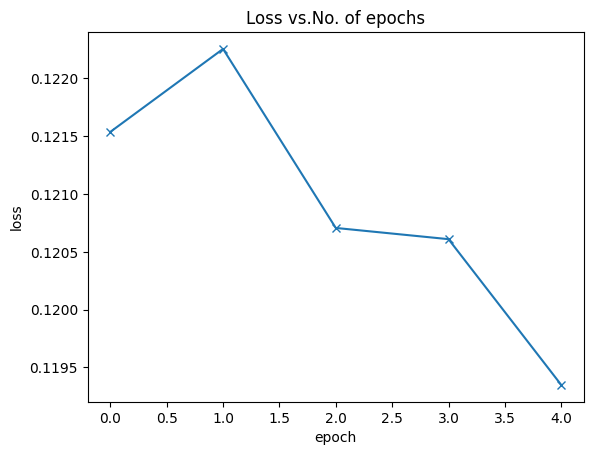

In [312]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs.No. of epochs')

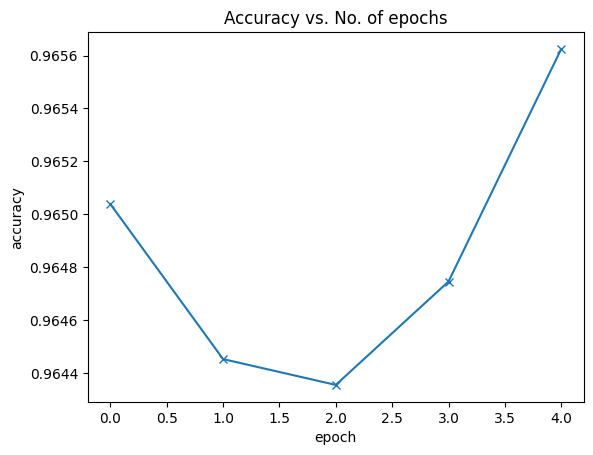

In [319]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

In [327]:
test_dataset = MNIST(root='data/', train= False, transform=ToTensor)

In [326]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])


In [343]:
def predict_image(img,model):
    model.eval()
    xb = to_device(img.unsqueeze(0), device)
    yb = model(yb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [338]:
def predict_image(image, model):
    model.eval()
    with torch.no_grad():
        # Add batch dimension: [1, 1, 28, 28]
        image = image.unsqueeze(0)
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()


In [339]:
from torchvision.datasets import MNIST

dataset = MNIST(root='data/', train=True, transform=transform, download=True)


In [340]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:',predict_image(img, model))

TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given

In [346]:
from torchvision import datasets, transforms

# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load test dataset (MNIST as an example)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transform, download=True)


In [347]:
img, label = test_dataset[0]  # This assigns 'img' and 'label'


In [348]:
print("Type of img:", type(img))
print("Shape of img:", img.shape)


Type of img: <class 'torch.Tensor'>
Shape of img: torch.Size([1, 28, 28])


In [ ]:
Type of img: <class 'torch.Tensor'>
Shape of im